<a href="https://colab.research.google.com/github/DiklaGelbard/kaggle_notebooks/blob/main/diabetes_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [ ]:
#@title Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import pprint
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
np.random.seed(0)

import os

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
#@title Useful functions
def get_stacked_bar_plot(cols, xtickslabels=None, legend_mapper=None, kind="barh", proportions=True):
  if proportions:
    ax = data.groupby(cols).size().unstack(1).apply(lambda x: x/x.sum(), axis=1).plot(kind=kind, stacked=True)
  else:
    ax = data.groupby(cols).size().unstack(1).plot(kind=kind, stacked=True)
  if xtickslabels is not None:
    labels = ax.get_xticklabels() if kind=="bar" else ax.get_yticklabels()
    ticks =  ax.get_xticks() if kind=="bar" else  ax.get_yticks()
    tickslabels = [xtickslabels[a.get_text()] for a in labels]
    if kind == "bar":
      ax.set_xticks(ticks=ticks, labels = tickslabels, rotation=45, ha='right', rotation_mode='anchor')
      plt.rcParams["figure.figsize"] = (6,10)
    else:
      ax.set_yticks(ticks=ticks, labels = tickslabels, rotation=10, ha='right', rotation_mode='anchor')
      plt.rcParams["figure.figsize"] = (10, 6)
  if legend_mapper is not None:
      labels = [legend_mapper[a.get_text()] for a in ax.get_legend().texts]
      ax.set_label(labels)
  plt.tight_layout()
  return ax

## Read and pre-process Data

### Load dataset

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"diklagel","key":"8f40772177035c67bbbf281673a72750"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d brandao/diabetes
! mkdir diabetes
! unzip diabetes.zip -d diabetes

  0% 0.00/4.41M [00:00<?, ?B/s]
100% 4.41M/4.41M [00:00<00:00, 134MB/s]
Archive:  diabetes.zip
  inflating: diabetes/description.pdf  
  inflating: diabetes/diabetic_data.csv  


In [ ]:
df = pd.read_csv("diabetes/diabetic_data.csv")

In [ ]:
# Categorical columns mapping (taken from external table)
admission_type_id = dict([(str(i+1), a) for i, a in enumerate(["Emergency", "Urgent", "Elective", "Newborn", "Not Available", "NULL", "Trauma Center", "Not Mapped"])])
discharge_disposition_id = dict([(str(i+1), a) for i, a in enumerate(["Discharged to home","Discharged/transferred to another short term hospital","Discharged/transferred to SNF","Discharged/transferred to ICF","Discharged/transferred to another type of inpatient care institution","Discharged/transferred to home with home health service","Left AMA","Discharged/transferred to home under care of Home IV provider","Admitted as an inpatient to this hospital","Neonate discharged to another hospital for neonatal aftercare","Expired","Still patient or expected to return for outpatient services","Hospice / home","Hospice / medical facility","Discharged/transferred within this institution to Medicare approved swing bed","Discharged/transferred/referred another institution for outpatient services","Discharged/transferred/referred to this institution for outpatient services","NULL","Expired at home. Medicaid only, hospice.","Expired in a medical facility. Medicaid only, hospice.","Expired, place unknown. Medicaid only, hospice.","Discharged/transferred to another rehab fac including rehab units of a hospital .","Discharged/transferred to a long term care hospital.","Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.","Not Mapped","Unknown/Invalid","Discharged/transferred to a federal health care facility.","Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital","Discharged/transferred to a Critical Access Hospital (CAH).","Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere"])])
admission_source_id = dict([(str(i+1), a) for i, a in enumerate(["Physician Referral","Clinic Referral","HMO Referral","Transfer from a hospital","Transfer from a Skilled Nursing Facility (SNF)","Transfer from another health care facility","Emergency Room","Court/Law Enforcement","Not Available","Transfer from critial access hospital","Normal Delivery","Premature Delivery","Sick Baby","Extramural Birth","Not Available","NULL","Transfer From Another Home Health Agency","Readmission to Same Home Health Agency","Not Mapped","Unknown/Invalid","Transfer from hospital inpt/same fac reslt in a sep claim","Born inside this hospital","Born outside this hospital","Transfer from Ambulatory Surgery Center","Transfer from Hospice"])])

### Explore the table

In [ ]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Handle number_of_encounters per patient

*   As in the original paper, I will keep only the first visit for each patient


number_of_encounters distribution:
1     54745
2     10434
3      3328
4      1421
5       717
6       346
7       207
8       111
9        70
10       42
11       20
12       19
13       14
14        5
15        9
16        4
17        3
18        6
19        3
20        6
21        1
22        2
23        3
28        1
40        1
dtype: int64


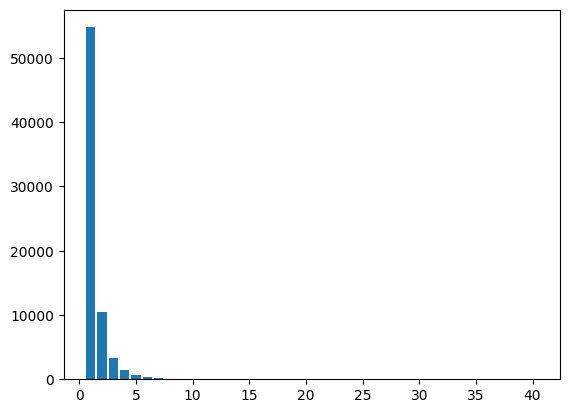

In [ ]:
number_of_encounters = df.groupby("patient_nbr").size()
print("number_of_encounters distribution:")
hist_number_of_encounters = number_of_encounters.value_counts().sort_index()
print(hist_number_of_encounters)
plt.bar(hist_number_of_encounters.index, hist_number_of_encounters)
df = df.join(pd.DataFrame(number_of_encounters, columns=["encounters_total_num"]), on = "patient_nbr", how = "left").sort_values(by="encounters_total_num", ascending=False)

In [ ]:
# Select first encounter per patient
data = df.sort_values(by="encounter_id").groupby("patient_nbr").first()

### Filter data by discharge_disposition_id column
*   As in the original paper, I will filter out death cases



<ipython-input-2-8264cbb1c31d>:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Axes: ylabel='discharge_disposition_id'>

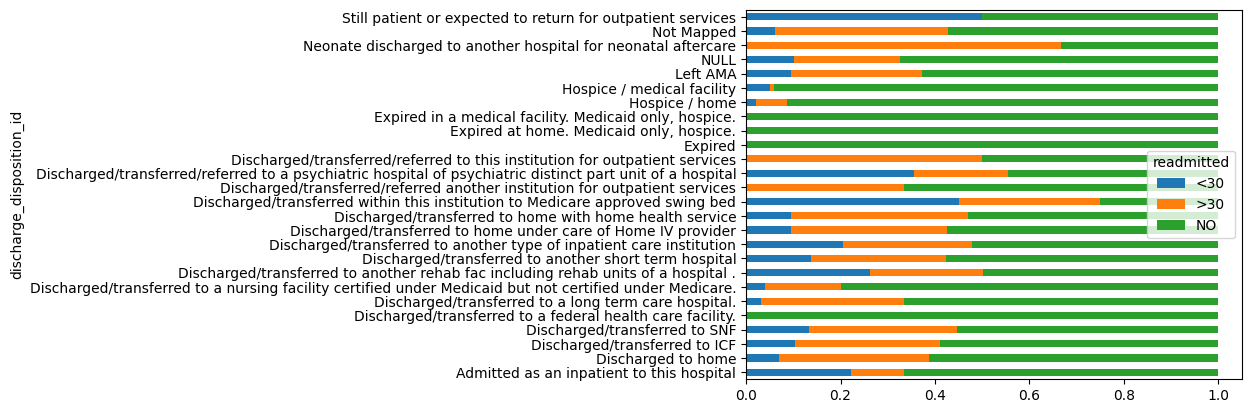

In [ ]:
# Converting to categories names
data.loc[:, "discharge_disposition_id"] = data.discharge_disposition_id.apply(lambda x: discharge_disposition_id[str(x)]).values
get_stacked_bar_plot(["discharge_disposition_id","readmitted"])

In [ ]:
# Drop discharge_disposition s.a expired or hospice
discharge_disposition_ids_to_remove = ["Expired", "Hospice / home", "Hospice / medical facility", "Expired at home. Medicaid only, hospice.", "Expired in a medical facility. Medicaid only, hospice."]
data = data.loc[~data.discharge_disposition_id.isin(discharge_disposition_ids_to_remove), :]

In [ ]:
print("discharge_disposition_id distribution")
data.groupby("discharge_disposition_id").size().sort_values(ascending=False)

discharge_disposition_id distribution


discharge_disposition_id
Discharged to home                                                                                           44317
Discharged/transferred to SNF                                                                                 8784
Discharged/transferred to home with home health service                                                       8289
NULL                                                                                                          2474
Discharged/transferred to another short term hospital                                                         1539
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1410
Discharged/transferred to another type of inpatient care institution                                           913
Not Mapped                                                                                                     778
Discharged/transferred to ICF                          

### Admission type

In [ ]:
admission_type_id_buckets = {"Emergency": [1, 2, 7], "Elective": [3], "Newborn": [4], "NULL": [5,6,8]}
admission_type_id_categories = dict((i,key) for key, item in admission_type_id_buckets.items() for i in item)
data.loc[:, "admission_type_id"] = data.admission_type_id.apply(lambda x: admission_type_id_categories[x]).values

<ipython-input-13-3ceac59a5de4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "admission_type_id"] = data.admission_type_id.apply(lambda x: admission_type_id_categories[x]).values


### Admission source

<ipython-input-14-dfa625ede893>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "admission_source_id"] = data.admission_source_id.apply(lambda x: admission_source_id[str(x)]).values


<Axes: ylabel='admission_source_id'>

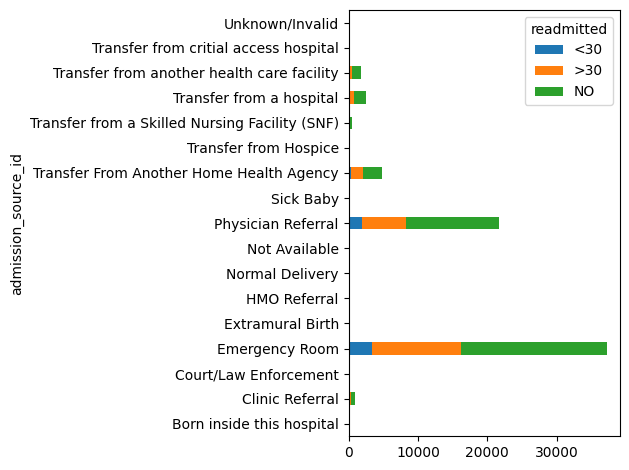

In [ ]:
#@title Converting to categories names - most of the data comes from Emergency Room and Physician Referral
data.loc[:, "admission_source_id"] = data.admission_source_id.apply(lambda x: admission_source_id[str(x)])
get_stacked_bar_plot(["admission_source_id","readmitted"], proportions=False)

### Age Columnn

In [ ]:
#@title Dividing age into buckets as shown in the paper
buckets = {"0-30": [0,10,20], "30-60": [30,40,50], "60-100": [60, 70, 80, 90]}
age_dict = dict((i,key) for key, item in buckets.items() for i in item)
data.loc[:, "original_age"] = data.loc[:, "age"].values
data.loc[:, "age"] = data.loc[:, "original_age"].apply(lambda x: age_dict[int(x.split("-")[0][1:])])
data.age.value_counts()

60-100    46296
30-60     21869
0-30       1808
Name: age, dtype: int64

### Mapping diagnoses to disease_groups

In [ ]:
#@title Main disease groups as described in the original paper
disease_groups = {"Circulatory": list(range(390,460)) + [785],
                  "Respiratory": list(range(460,520)) + [786],
                  "Digestive": list(range(520,579)) + [787],
                  "Diabetes": [250],
                  "Injury": list(range(800, 1000)),
                  "Musculoskeletal": list(range(710, 740)),
                  "Genitourinary": list(range(580,630)) + [788],
                  "Neoplasms": list(range(140,240)),
                 }
disease_groups_df = pd.DataFrame([{"disease_group":d, "diag_id":str(i)} for d in disease_groups.keys() for i in disease_groups[d] ])
disease_groups_df.head()

,disease_group,diag_id
0,Circulatory,390
1,Circulatory,391
2,Circulatory,392
3,Circulatory,393
4,Circulatory,394


In [ ]:
#@title Add disease_group for each diagnosis column
def add_disease_group_column(data, diag_col, disease_group_col):
    data = pd.merge(data, disease_groups_df.rename(columns = {'disease_group':disease_group_col}), left_on=diag_col, right_on="diag_id", how="left").fillna({disease_group_col: "Other"}).drop("diag_id", axis=1)
    return data

for i in range(1,4):
    data = add_disease_group_column(data, diag_col="diag_%d" %i, disease_group_col="disease_group_%d" %i)

data[["diag_1", "diag_2", "diag_3",'disease_group_1', 'disease_group_2', 'disease_group_3']].head()

,diag_1,diag_2,diag_3,disease_group_1,disease_group_2,disease_group_3
0,401,997,560,Circulatory,Injury,Digestive
1,722,305,250,Musculoskeletal,Other,Diabetes
2,820,493,E880,Injury,Respiratory,Other
3,274,427,416,Other,Circulatory,Circulatory
4,590,220,250,Genitourinary,Neoplasms,Diabetes


#### Disease groups one hot encoding and PCA for visualization

In [ ]:
#@title One-Hot encoding
disease_groups_list =["disease_group_1", "disease_group_2", "disease_group_3"]
one_hot_encoded_disease_groups = pd.get_dummies(data, columns=disease_groups_list, drop_first=False)
one_hot_encoded_disease_groups.loc[:, "total_diagnoses"] = one_hot_encoded_disease_groups.loc[:,[f"{diag}_{disease}" for diag in disease_groups_list for disease in disease_groups.keys()]].sum(axis=1)
for disease in disease_groups.keys():
    one_hot_encoded_disease_groups.loc[:, disease] = (one_hot_encoded_disease_groups.loc[:,[f"{diag}_{disease}" for diag in disease_groups_list]].sum(axis=1) /
                                                      (one_hot_encoded_disease_groups.loc[:, "total_diagnoses"] + 0.00001)).round(3)
one_hot_encoded_disease_groups = one_hot_encoded_disease_groups[disease_groups.keys()]
one_hot_encoded_disease_groups.head()

,Circulatory,Respiratory,Digestive,Diabetes,Injury,Musculoskeletal,Genitourinary,Neoplasms
0,0.333,0.0,0.333,0.000,0.333,0.0,0.000,0.000
1,0.000,0.0,0.000,0.500,0.000,0.5,0.000,0.000
2,0.000,0.5,0.000,0.000,0.500,0.0,0.000,0.000
3,1.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000
4,0.000,0.0,0.000,0.333,0.000,0.0,0.333,0.333


In [ ]:
#@title Visualize PCA
from sklearn.decomposition import PCA
pca_disease_groups = PCA(n_components=2).fit(one_hot_encoded_disease_groups.values)
import plotly.express as px
category_vectors_disease_groups = pca_disease_groups.components_.T
category_vector_frame_disease_groups=pd.DataFrame(category_vectors_disease_groups, index=disease_groups.keys(),
                                   columns=['col1', 'col2']).reset_index()
px.scatter(category_vector_frame_disease_groups, x='col1', y='col2', color='index')

### Process 23 medications columns

In [ ]:
#@title medications column names
medications = ['metformin',
               'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
               'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
               'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
               'tolazamide', 'examide', 'citoglipton', 'insulin',
               'glyburide-metformin', 'glipizide-metformin',
               'glimepiride-pioglitazone', 'metformin-rosiglitazone',
               'metformin-pioglitazone']

In [ ]:
#@title Drop medications with single value over the dataset
med_describe = data[medications].describe()
medications_to_drop = list(med_describe.columns[med_describe.loc["unique"] == 1])
print("Dropping out the following medications:", medications_to_drop)
data = data.drop(medications_to_drop, axis=1)
medications = [m for m in medications if m not in medications_to_drop]

Dropping out the following medications: ['examide', 'citoglipton', 'glimepiride-pioglitazone']


When examining the distribution of medication prescriptions among patients, it becomes apparent that numerous medications are prescribed with great rarity. This raises the issue of whether these medications should be excluded from our analysis or not.

Text(0.5, 1.0, 'Medications prescriptions distribution')

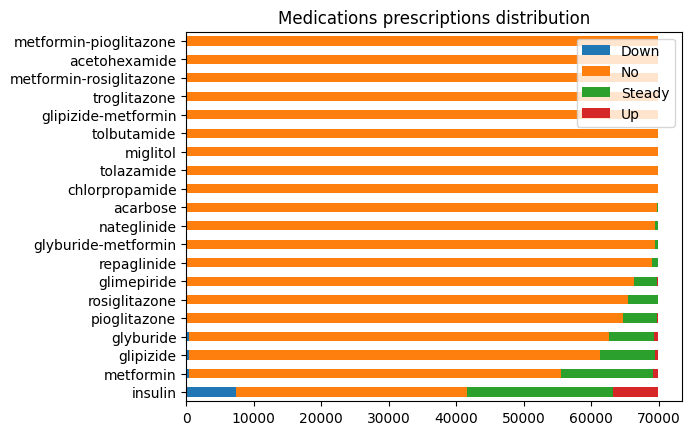

In [ ]:
#@title Medications prescriptions bar plot
medications_value_counts = data[medications].apply(lambda x: x.value_counts(), axis=0).fillna(0).transpose().sort_values(by="No")
medications_value_counts.plot.barh(stacked=True)
plt.legend(loc='upper right')
plt.title("Medications prescriptions distribution")

Text(0.5, 1.0, 'num_medications distribution among patients')

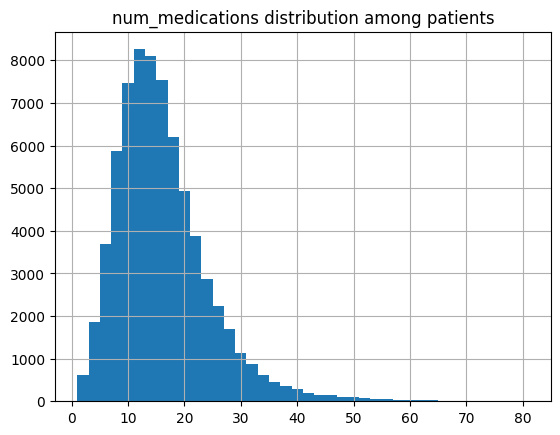

In [ ]:
#@title Number of medications per patient - distribution
data.num_medications.hist(bins=40)
plt.title("num_medications distribution among patients")

#### Medications Binarization and PCA

In [ ]:
trans_med = {"Steady": 1, "Up": 1, "Down": 1, "No": 0}
med_data = data[medications].apply(lambda x: x.map(trans_med))

In [ ]:
#@title PCA visualization
from sklearn.decomposition import PCA
pca_med_data = PCA(n_components=2).fit(med_data.values)
category_vectors_med = pca_med_data.components_.T
category_vector_frame_med=pd.DataFrame(category_vectors_med, index=medications,
                                       columns=['col1', 'col2']).reset_index()
px.scatter(category_vector_frame_med, x='col1', y='col2', color='index')

### Basic feature selection

In [ ]:
#@title Our target variable is the readmitted column, min expected precision would be the readmission prevelance in the dataset
y = data.loc[:, 'readmitted'].apply(lambda x: 1 if x != "NO" else 0)
readmission_counts = y.value_counts()
print("readmission value counts:")
print(readmission_counts)
print("Min expected precision (readmission prevelance):", readmission_counts[1] / readmission_counts.sum())

readmission value counts:
0    41474
1    28499
Name: readmitted, dtype: int64
Min expected precision (readmission prevelance): 0.4072856673288268


In [ ]:
#@title Data preperation
cols_to_choose = ['race', 'gender', 'age', 'admission_type_id',
                  'discharge_disposition_id', 'admission_source_id', 'time_in_hospital','num_lab_procedures',
                  'num_procedures', 'num_medications', 'number_outpatient',
                  'number_emergency', 'number_inpatient', 'change', 'diabetesMed', "max_glu_serum", "A1Cresult"]
processed_data = data[cols_to_choose].copy()

categorical_features = ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id','change', 'diabetesMed', "max_glu_serum", "A1Cresult"]
processed_data = pd.get_dummies(processed_data, columns=categorical_features, drop_first=True)

processed_data = pd.concat([processed_data, med_data, one_hot_encoded_disease_groups], axis=1)
processed_data.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,race_AfricanAmerican,race_Asian,race_Caucasian,...,metformin-rosiglitazone,metformin-pioglitazone,Circulatory,Respiratory,Digestive,Diabetes,Injury,Musculoskeletal,Genitourinary,Neoplasms
0,8,77,6,33,0,0,0,0,0,1,...,0,0,0.333,0.0,0.333,0.000,0.333,0.0,0.000,0.000
1,2,49,1,11,0,0,0,0,0,1,...,0,0,0.000,0.0,0.000,0.500,0.000,0.5,0.000,0.000
2,4,68,2,23,0,0,0,0,0,1,...,0,0,0.000,0.5,0.000,0.000,0.500,0.0,0.000,0.000
3,3,46,0,20,0,0,0,0,0,1,...,0,0,1.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000
4,5,49,0,5,0,0,0,1,0,0,...,0,0,0.000,0.0,0.000,0.333,0.000,0.0,0.333,0.333


#### Feature variance - basic feature selection based on dropping features with low variance

In [ ]:
#@title Features variance distribution
features_std = processed_data.std(axis=0)
box_df = pd.DataFrame({'std': features_std, 'feature_name': processed_data.columns})
px.box(box_df, y='std', hover_data=['feature_name'], title=f'Boxplot of features std distribuiton over {len(processed_data.columns)} features')

<Axes: title={'center': 'Top 20 variable features'}, ylabel='feature_name'>

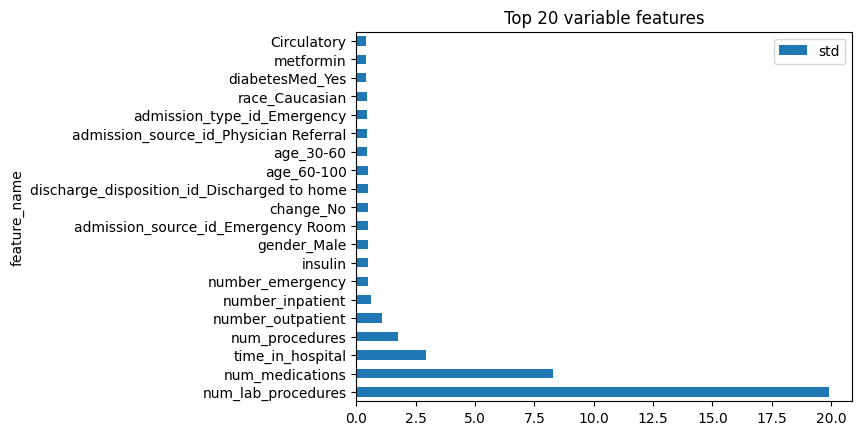

In [ ]:
box_df.set_index('feature_name').sort_values(by='std', ascending=False).head(20).plot.barh(title="Top 20 variable features")

<Axes: title={'center': 'least 20 variable features'}, ylabel='feature_name'>

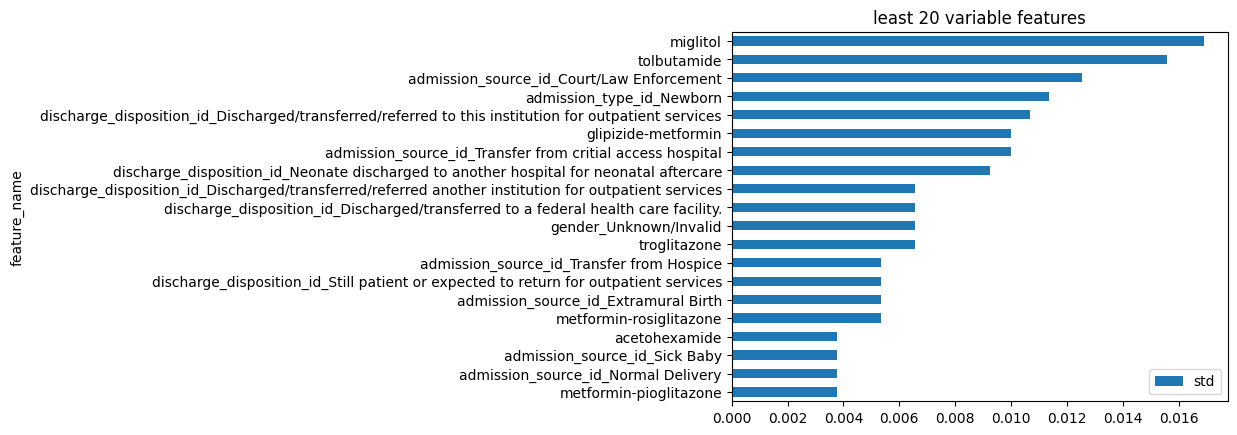

In [ ]:
box_df.set_index('feature_name').sort_values(by='std', ascending=True).head(20).plot.barh(title="least 20 variable features")

In [ ]:
#@title Remove features with low variance - dropping the lowest 30% quantile
q = features_std.quantile(0.3)
print("dropping out the following low var features", processed_data.columns[features_std <= q])
selected_fetures = processed_data.columns[features_std > q]

dropping out the following low var features Index(['gender_Unknown/Invalid', 'admission_type_id_Newborn',
       'discharge_disposition_id_Discharged/transferred to a federal health care facility.',
       'discharge_disposition_id_Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.',
       'discharge_disposition_id_Discharged/transferred to home under care of Home IV provider',
       'discharge_disposition_id_Discharged/transferred within this institution to Medicare approved swing bed',
       'discharge_disposition_id_Discharged/transferred/referred another institution for outpatient services',
       'discharge_disposition_id_Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
       'discharge_disposition_id_Discharged/transferred/referred to this institution for outpatient services',
       'discharge_disposition_id_Neonate discharged to another hospital for neonatal afte

### Train-Test split

In [ ]:
# Split to train and test data
X_train, X_test, y_train, y_test = train_test_split(processed_data.loc[:,selected_fetures], y, test_size=0.2, random_state=42)

## Baseline Model
*Using features from the paper



In [ ]:
#@title Logisitic regrssion functions
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve
from sklearn.metrics import auc, make_scorer

def pr_auc(y_true, y_pred):
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  auc_precision_recall = auc(recall, precision)
  return auc_precision_recall

pr_auc_score = make_scorer(pr_auc, greater_is_better=True, needs_proba=True)

def add_to_log(s, log):
  log.append(s)

def plot_curve_and_auc(X, Y, thresholds, title, xlabel="recall", ylabel="precision", ax=None):
  # Use AUC function to calculate the area under the curve
  result_auc = auc(X, Y)
  title += 'AUC={0:0.2f}\n'.format(result_auc)
  if ax is None:
    fig, ax = plt.subplots(1,1)
  ax.plot(X, Y)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  return result_auc

def calc_pr_curve(y_test, y_score, title="", ax=None):
  # Average precision score - AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:
  average_precision = average_precision_score(y_test, y_score)
  # Data to plot precision-recall curve
  precision, recall, thresholds = precision_recall_curve(y_test, y_score) # Compute precision-recall pairs for different probability thresholds.
  title += 'PR curve: Average Precision={0:0.2f}, '.format(average_precision)
  auc_precision_recall = plot_curve_and_auc(recall, precision, thresholds, title, ax=ax)
  return recall, precision, thresholds, auc_precision_recall

def calc_roc_curve(y_test, y_score, title="", ax=None):
  fpr, tpr, thresholds = roc_curve(y_test, y_score)
  title += 'ROC curve: '
  auc_roc = plot_curve_and_auc(fpr, tpr, thresholds, title,  xlabel="False Positive Rate", ylabel="True Positive Rate", ax=ax)
  return fpr, tpr, thresholds, auc_roc

def run_model(classifier, X_train, y_train, X_test, y_test, title=""):
  classifier.fit(X_train, y_train)
  # Get the predicited probability of testing data
  y_score = classifier.predict_proba(X_test)[:, 1]
  return classifier, y_score

def calc_curve(y_test, y_score, auc_curve, title="", ax=None):
  if auc_curve == "pr":
    return calc_pr_curve(y_test, y_score, title=title, ax=ax)
  if auc_curve == "roc":
    return calc_roc_curve(y_test, y_score, title=title, ax=ax)
  return None

def run_logisitic_regression(X_train, y_train, X_test, y_test, log,  model_parmas={"penalty":None, "max_iter": 1000, "random_state": 42}):
  col_names = list(X_train.columns)
  jumps = 4
  col_str = ",\n".join([str(col_names[start:np.min([start+jumps, len(col_names)]):1]).replace("[","").replace("]","") for start in range(0, len(col_names), jumps)])
  model_title = f'Logisitc Regression with the following features:'
  add_to_log(model_title + str(col_names) +'\n', log)
  title = f'{model_title}\n[{col_str}]\n' if len(X_train.columns) < 8 else 'Logisitc Regression\n'
  # Create classifier using logistic regression
  classifier = LogisticRegression(**model_parmas) # penalty=None because the data is not scaled, so I would like to avoid regularization
  classifier, y_score = run_model(classifier, X_train, y_train, X_test, y_test, title)
  add_to_log(f'classifier coefficients: {list(zip(X_train.columns, classifier.coef_[0]))}\n', log)
  return classifier, y_score, title

def run_model_and_plot(X_train, y_train, X_test, y_test, axs=None, auc_curves=["pr"], model_parmas={"penalty":None, "max_iter": 1000, "random_state": 42}):
  log = []
  classifier, y_score, title = run_logisitic_regression(X_train, y_train, X_test, y_test, log, model_parmas=model_parmas)
  if axs is None:
    fig, axs = plt.subplots(1,len(auc_curves), figsize = (len(auc_curves)*6.5, 4.9))
  curve_results = []
  for ax, curve in zip(axs.flatten(), auc_curves):
    X,Y, thresholds, auc = calc_curve(y_test, y_score, curve, title=title, ax=ax)
    add_to_log(f'{curve} thresholds: {thresholds} \n', log)
    curve_results.append([X,Y, thresholds, auc])
  add_to_log('\n', log)
  return classifier, curve_results, log

I will use also the precision-recall curve in order to estimate my model
* When data is imbalanced, the ROC AUC might not reflect the true performance of the classifier.
* The definition of the False Positive Rate (FPR), is the number of false positives divided by the number of negative samples. FPR is considered better when it’s smaller since it indicates fewer false positives.
* In imbalanced data, the FPR tends to stay at small values due to the large numbers of negatives (i.e. making the denominator large). Thus, FPR becomes less informative for the model performance in this situation.
* In the plots below We can see that the ROC curve is less informative than the PR curve



(array([0., 1.]), array([0., 1.]), array([2, 1]), 0.5)

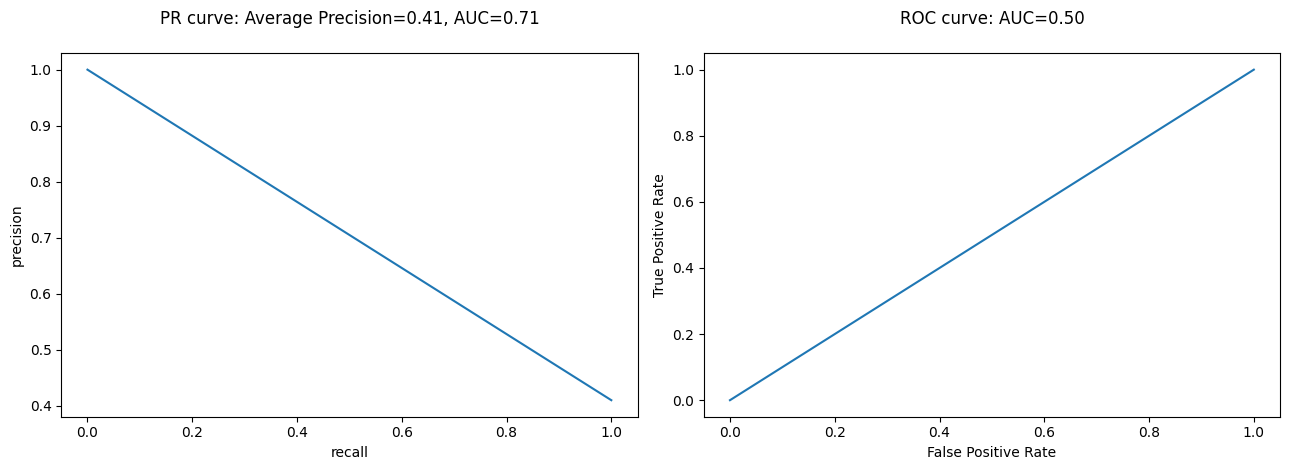

In [ ]:
#@title Baseline with true lables - compare between PR and ROC curves
y_score = [1] * len(y_test)
fig, ax = plt.subplots(1, 2, figsize = (2*6.5, 4.8), layout="tight")
calc_pr_curve(y_test, y_score, ax=ax[0])
calc_roc_curve(y_test, y_score, ax=ax[1])

### Baseline: use combinations of significant features from the paper:
A1Cresult (available measurement), A1Cresult (available measurement + value), change_No (Change in medication) and Age

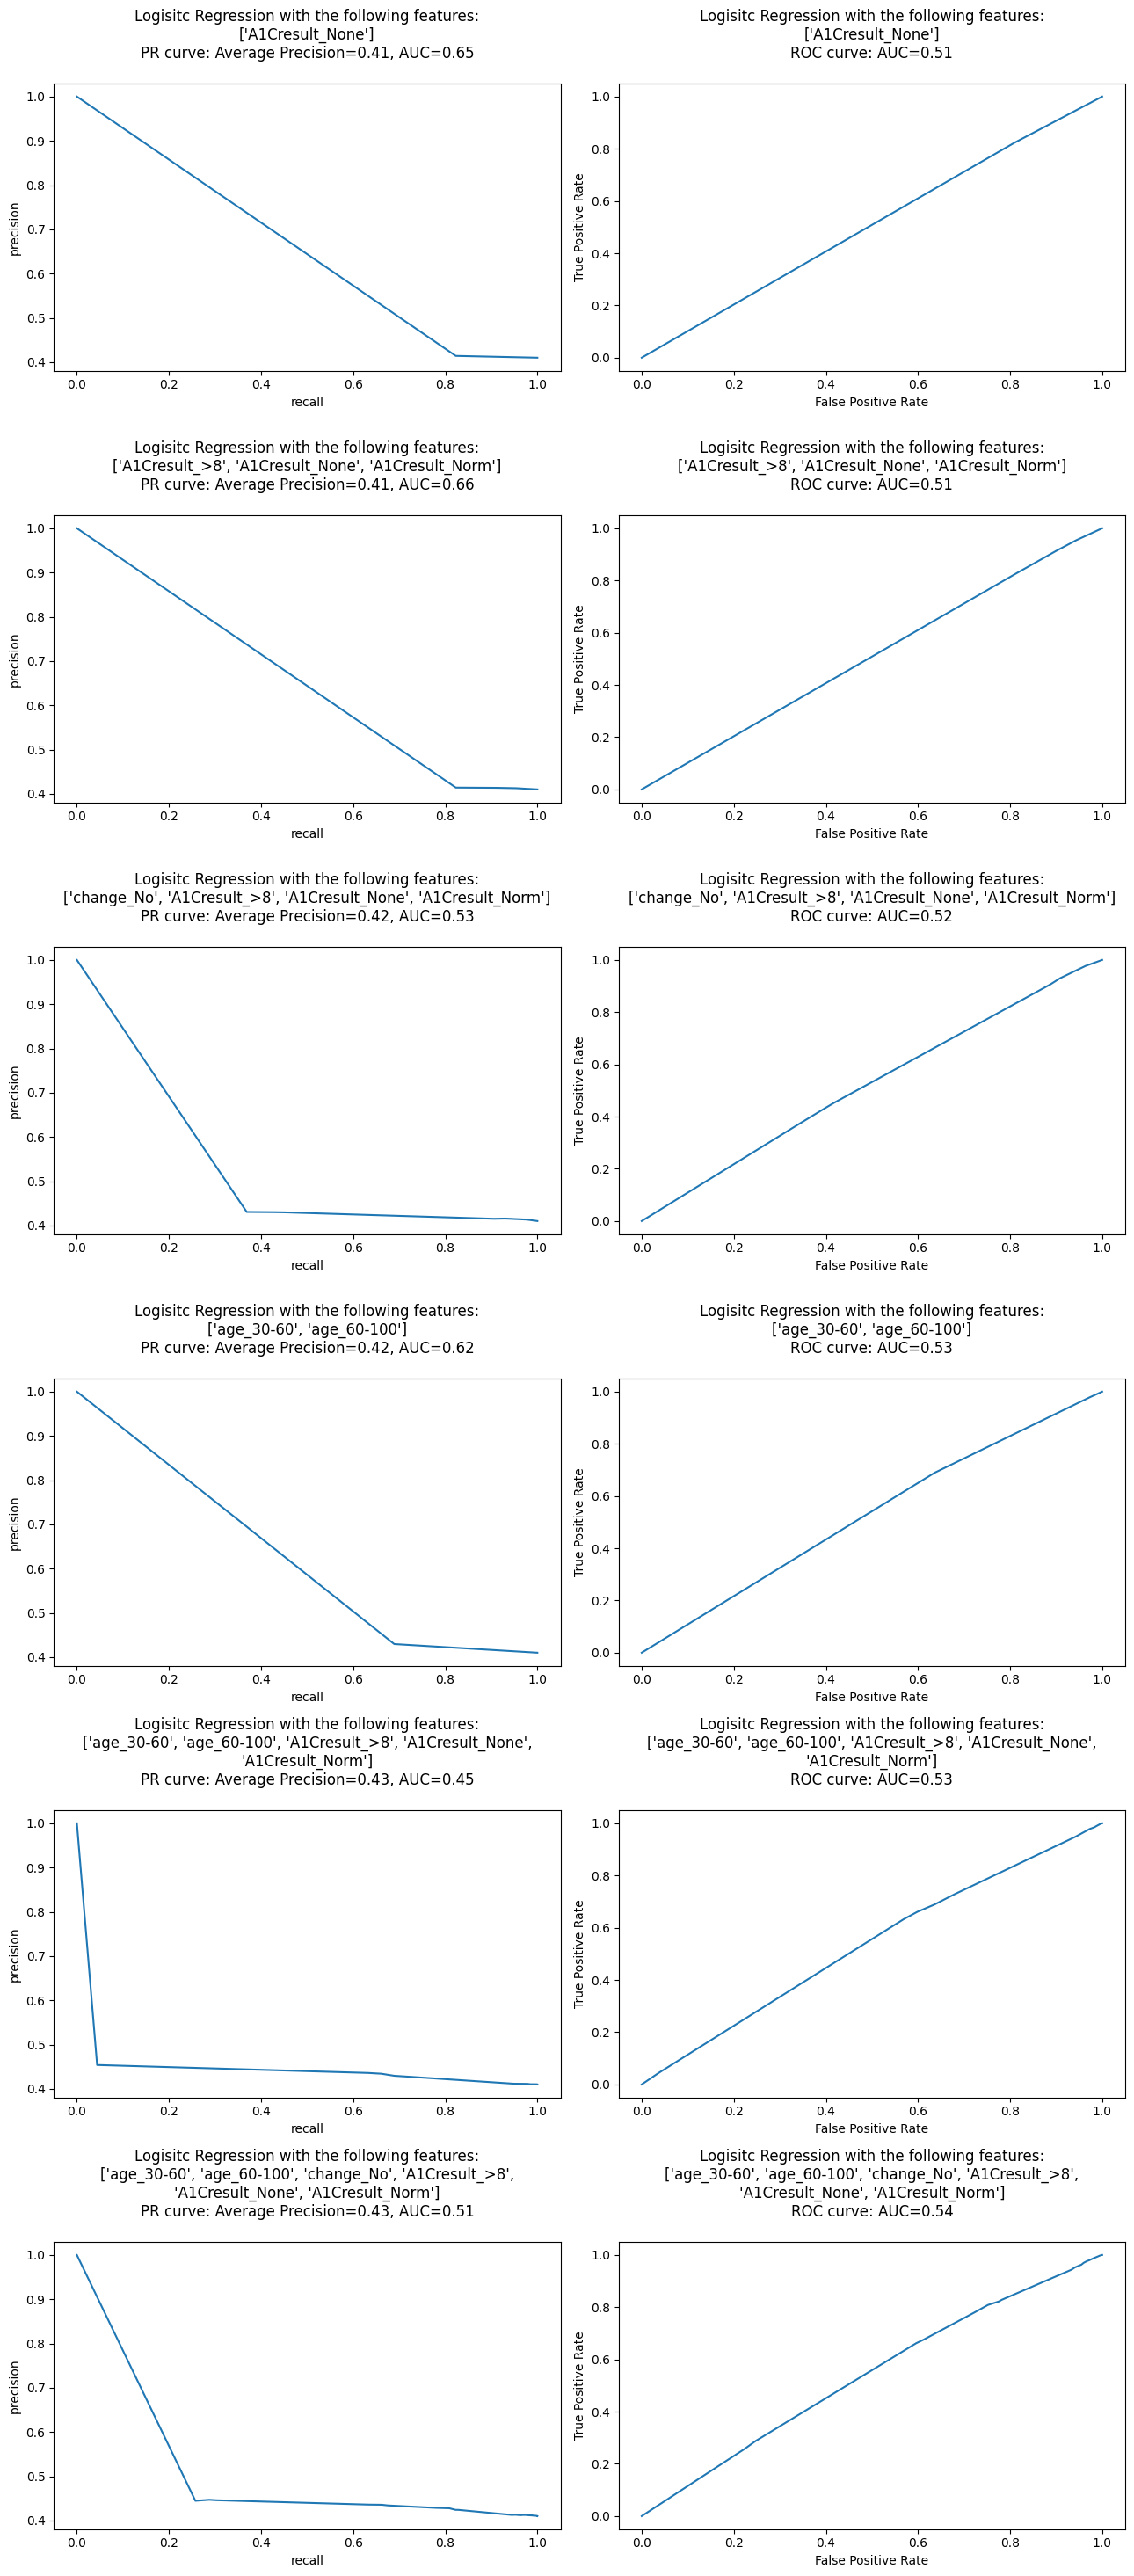

In [ ]:
#@title Plot PR and ROC curves
import math
A1Cresult_cols = [col for col in X_train.columns if "A1C" in col]
change_and_A1Cresult_cols = ['change_No'] + A1Cresult_cols
age_cols = [col for col in X_train.columns if "age" in col]

features_sets = [['A1Cresult_None'], A1Cresult_cols, change_and_A1Cresult_cols, age_cols, age_cols+A1Cresult_cols, age_cols+change_and_A1Cresult_cols]
# nrows = math.ceil(len(features_sets)/2)
nrows = len(features_sets)
fig, axs = plt.subplots(nrows, 2, figsize = (2*6.5, nrows*4.9), layout="tight")
logs = []
for i in range(nrows):
  _, _, log = run_model_and_plot(X_train.loc[:, features_sets[i]], y_train, X_test.loc[:, features_sets[i]], y_test, axs=axs[i, :], auc_curves=["pr", "roc"])
  logs.extend(log)

#### Print Parameters

In [ ]:
print(*logs)

Logisitc Regression with the following features:['A1Cresult_None']
 classifier coefficients: [('A1Cresult_None', 0.12280446086868788)]
 pr thresholds: [0.38255952 0.41195388] 
 roc thresholds: [1.41195388 0.41195388 0.38255952] 
 
 Logisitc Regression with the following features:['A1Cresult_>8', 'A1Cresult_None', 'A1Cresult_Norm']
 classifier coefficients: [('A1Cresult_>8', 0.0330970722156475), ('A1Cresult_None', 0.11455639306784375), ('A1Cresult_Norm', -0.08446180153340292)]
 pr thresholds: [0.36472522 0.38450936 0.39237151 0.41195358] 
 roc thresholds: [1.41195358 0.41195358 0.39237151 0.38450936 0.36472522] 
 
 Logisitc Regression with the following features:['change_No', 'A1Cresult_>8', 'A1Cresult_None', 'A1Cresult_Norm']
 classifier coefficients: [('change_No', -0.15557098197170086), ('A1Cresult_>8', 0.009576047184894345), ('A1Cresult_None', 0.1252565075204196), ('A1Cresult_Norm', -0.07505846348213246)]
 pr thresholds: [0.34908299 0.3663253  0.36855103 0.38520778 0.3958571  0.4031

### Use all columns

Logisitc Regression with the following features:['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender_Male', 'age_30-60', 'age_60-100', 'admission_type_id_Emergency', 'admission_type_id_NULL', 'discharge_disposition_id_Discharged to home', 'discharge_disposition_id_Discharged/transferred to ICF', 'discharge_disposition_id_Discharged/transferred to SNF', 'discharge_disposition_id_Discharged/transferred to a long term care hospital.', 'discharge_disposition_id_Discharged/transferred to another rehab fac including rehab units of a hospital .', 'discharge_disposition_id_Discharged/transferred to another short term hospital', 'discharge_disposition_id_Discharged/transferred to another type of inpatient care institution', 'discharge_disposition_id_Discharged/transferred to home with home health service', 'dischar

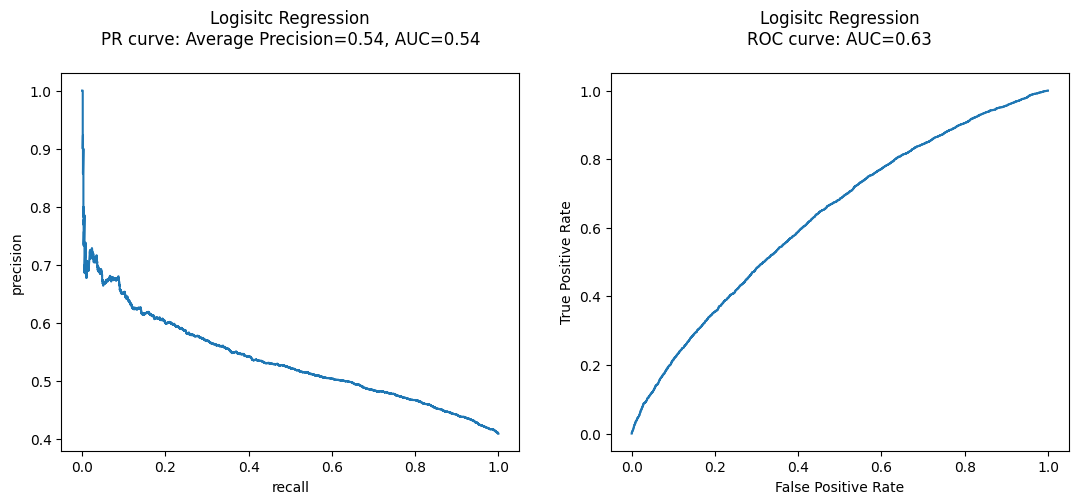

In [ ]:
_, _, log = run_model_and_plot(X_train, y_train, X_test, y_test, auc_curves=["pr", "roc"], model_parmas={"penalty":None, "max_iter": 10000, "random_state": 42, "solver": "saga"})
print(*log)

**Summary:**
Running a logistic regression on different feature sets shows increase in both the average precision and the ROC-AUC.
On the other hand, the AUC of the precision-recall curve decreases as the feature complexity increases.
Maintaining a balanced performance across all recall levels might be preferable.

* From sklearn: A system with high precision but low recall returns very few results, but most of its predicted labels are correct when compared to the training labels.
An ideal system with high precision and high recall will return many results, with all results labeled correctly.

## Advanced feature selection

In [ ]:
#@title Functions for plotting feature importance
def plot_and_select_features(feature_names, scores, xerr=None, top_features = 30, title = "Features scores", xlabel = "score", figsize=(10,6)):
    order = scores.argsort()[::-1]
    selected_fetures = list(feature_names[order][:top_features])
    plt.rcParams["figure.figsize"] = figsize
    if xerr:
      plt.barh(selected_fetures, scores[order][:top_features], xerr=xerr[order][:top_features])
    else:
      plt.barh(selected_fetures, scores[order][:top_features])
    plt.title(title)
    plt.ylabel("Feature name")
    plt.xlabel(xlabel)
    return selected_fetures

#### Univariate feature selection
* The reason these tests are called univariate tests is that they do not look at all the features collectively.
* In particular, it does not take into account the interaction between features.
* Instead, it looks at each feature separately and determines whether there is a significant relationship between that feature and the target.
* So if you have 10 features, the test will be repeated for each of the 10 features, one at a time, giving you a list of 10 scores/p-values.
'''

In [ ]:
#@title Linear Regression F-test (f_regression)
'''
The idea behind the scikit-learn f_regression method:
It breaks your group of features into several simple linear regression models and returns the F-score of that model as the F-score for that feature.
This test only verifies whether there is a linear relationship between each feature and the target.
It will fail to capture any non-linear relationship. If you wish to test a non-linear relationship, then you need to apply some feature transformation on your original features.
'''
from sklearn.feature_selection import f_regression
X = processed_data.loc[:,selected_fetures]

F, pval = f_regression(X, y)
F_df = pd.DataFrame({"F_score": F, "p_value": pval}, index=X.columns).sort_values(by="p_value")

pd.options.display.float_format = "{:,.5f}".format
F_df.head(20)

,F_score,p_value
number_inpatient,"1,527.06463",0.00000
number_emergency,417.07907,0.00000
Diabetes,394.98207,0.00000
age_60-100,351.03110,0.00000
number_outpatient,303.62251,0.00000
time_in_hospital,295.53431,0.00000
diabetesMed_Yes,261.88743,0.00000
age_30-60,259.09361,0.00000
admission_source_id_Emergency Room,241.26843,0.00000
num_lab_procedures,212.07548,0.00000


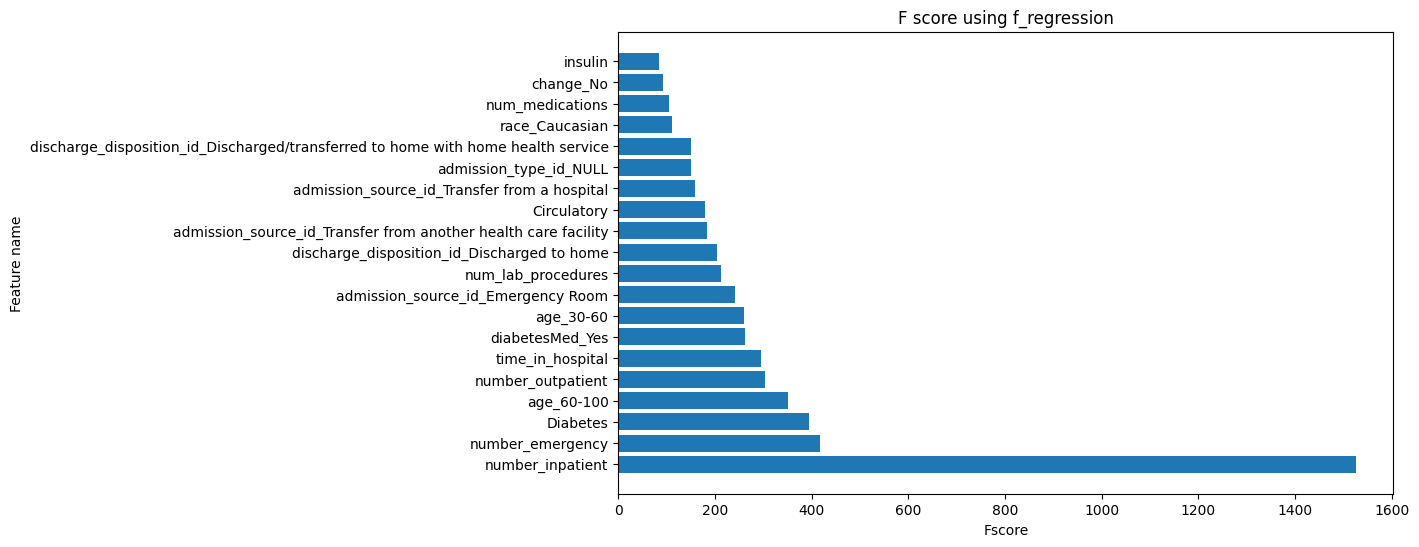

In [ ]:
selected_features_f_reg = plot_and_select_features(X.columns, F, top_features=20, title="F score using f_regression", xlabel="Fscore")

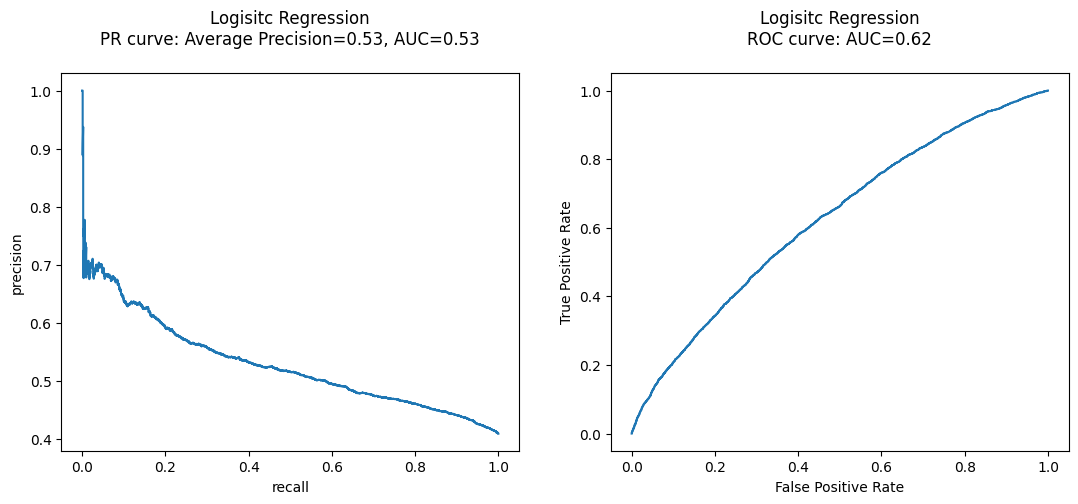

In [ ]:
#@title Logistic regression with top f_regression features
_, _, log = run_model_and_plot(X_train.loc[:, selected_features_f_reg], y_train, X_test.loc[:, selected_features_f_reg], y_test, auc_curves=["pr", "roc"])

### L1-based feature selection
* Run LogisiticRegression with L1 penalty

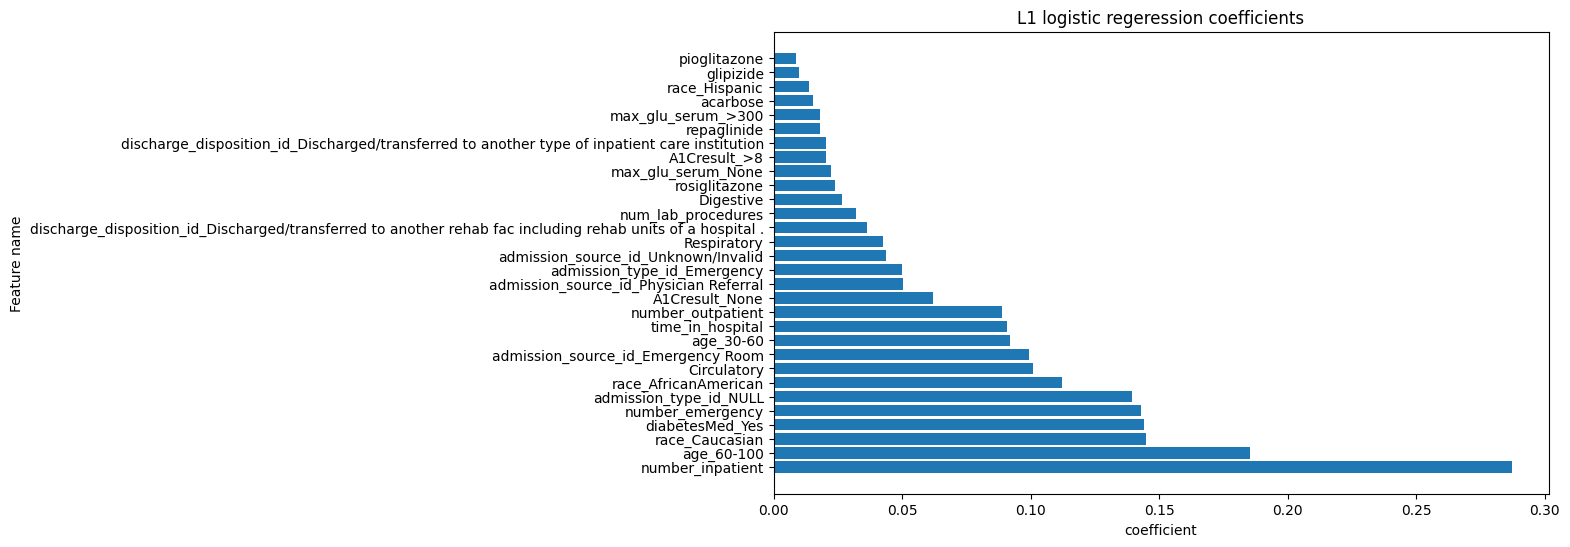

In [ ]:
from sklearn.preprocessing import StandardScaler

X_normalized = StandardScaler().fit_transform(X)

regularization_strength_inv = 1
clf_l1_LR = LogisticRegression(C=regularization_strength_inv, penalty="l1", tol=0.01, solver='saga')
clf_l1_LR.fit(X_normalized, y)
selected_features_l1_reg = plot_and_select_features(X.columns, clf_l1_LR.coef_.ravel(), top_features=30, title="L1 logistic regeression coefficients", xlabel="coefficient")

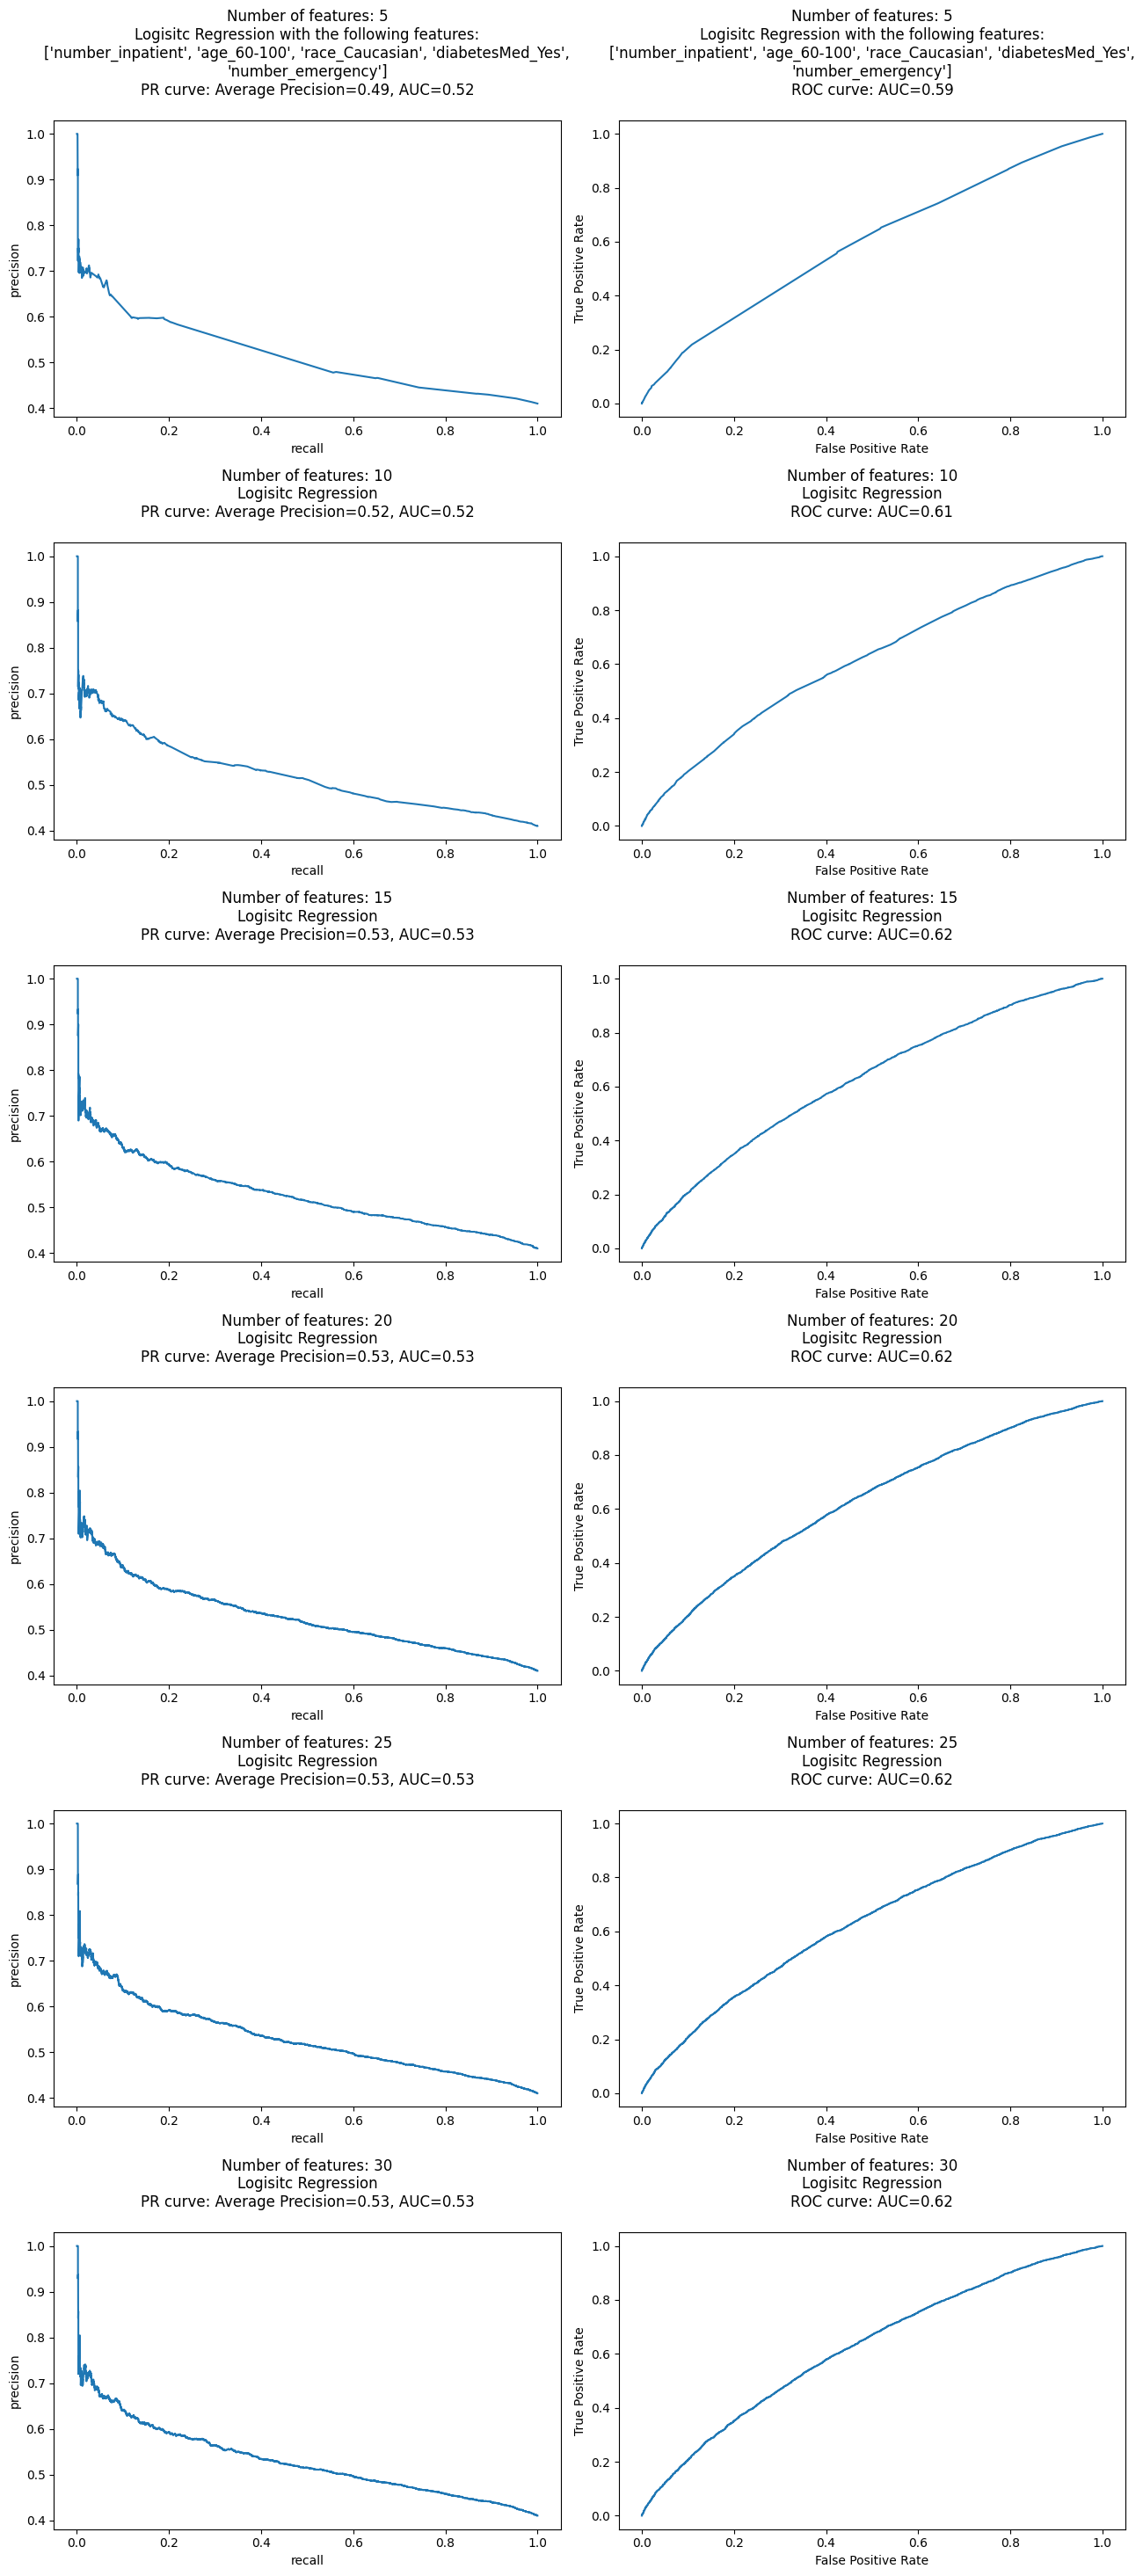

In [ ]:
#@title Logistic regression with top L1 logistic regeression features
set_sizes = [set_size for set_size in range(5,31, 5)]
nrows = len(set_sizes)
fig, axs = plt.subplots(nrows, 2, figsize = (2*6.5, nrows*4.9), layout="tight")
logs = []
for i in range(nrows):
  feature_list = selected_features_l1_reg[0:set_sizes[i]]
  _, _, log = run_model_and_plot(X_train.loc[:, feature_list], y_train, X_test.loc[:, feature_list], y_test, auc_curves=["pr", "roc"], axs=axs[i])
  for ax in axs[i]:
    ax.set_title(f'Number of features: {len(feature_list)}\n' + ax.get_title())

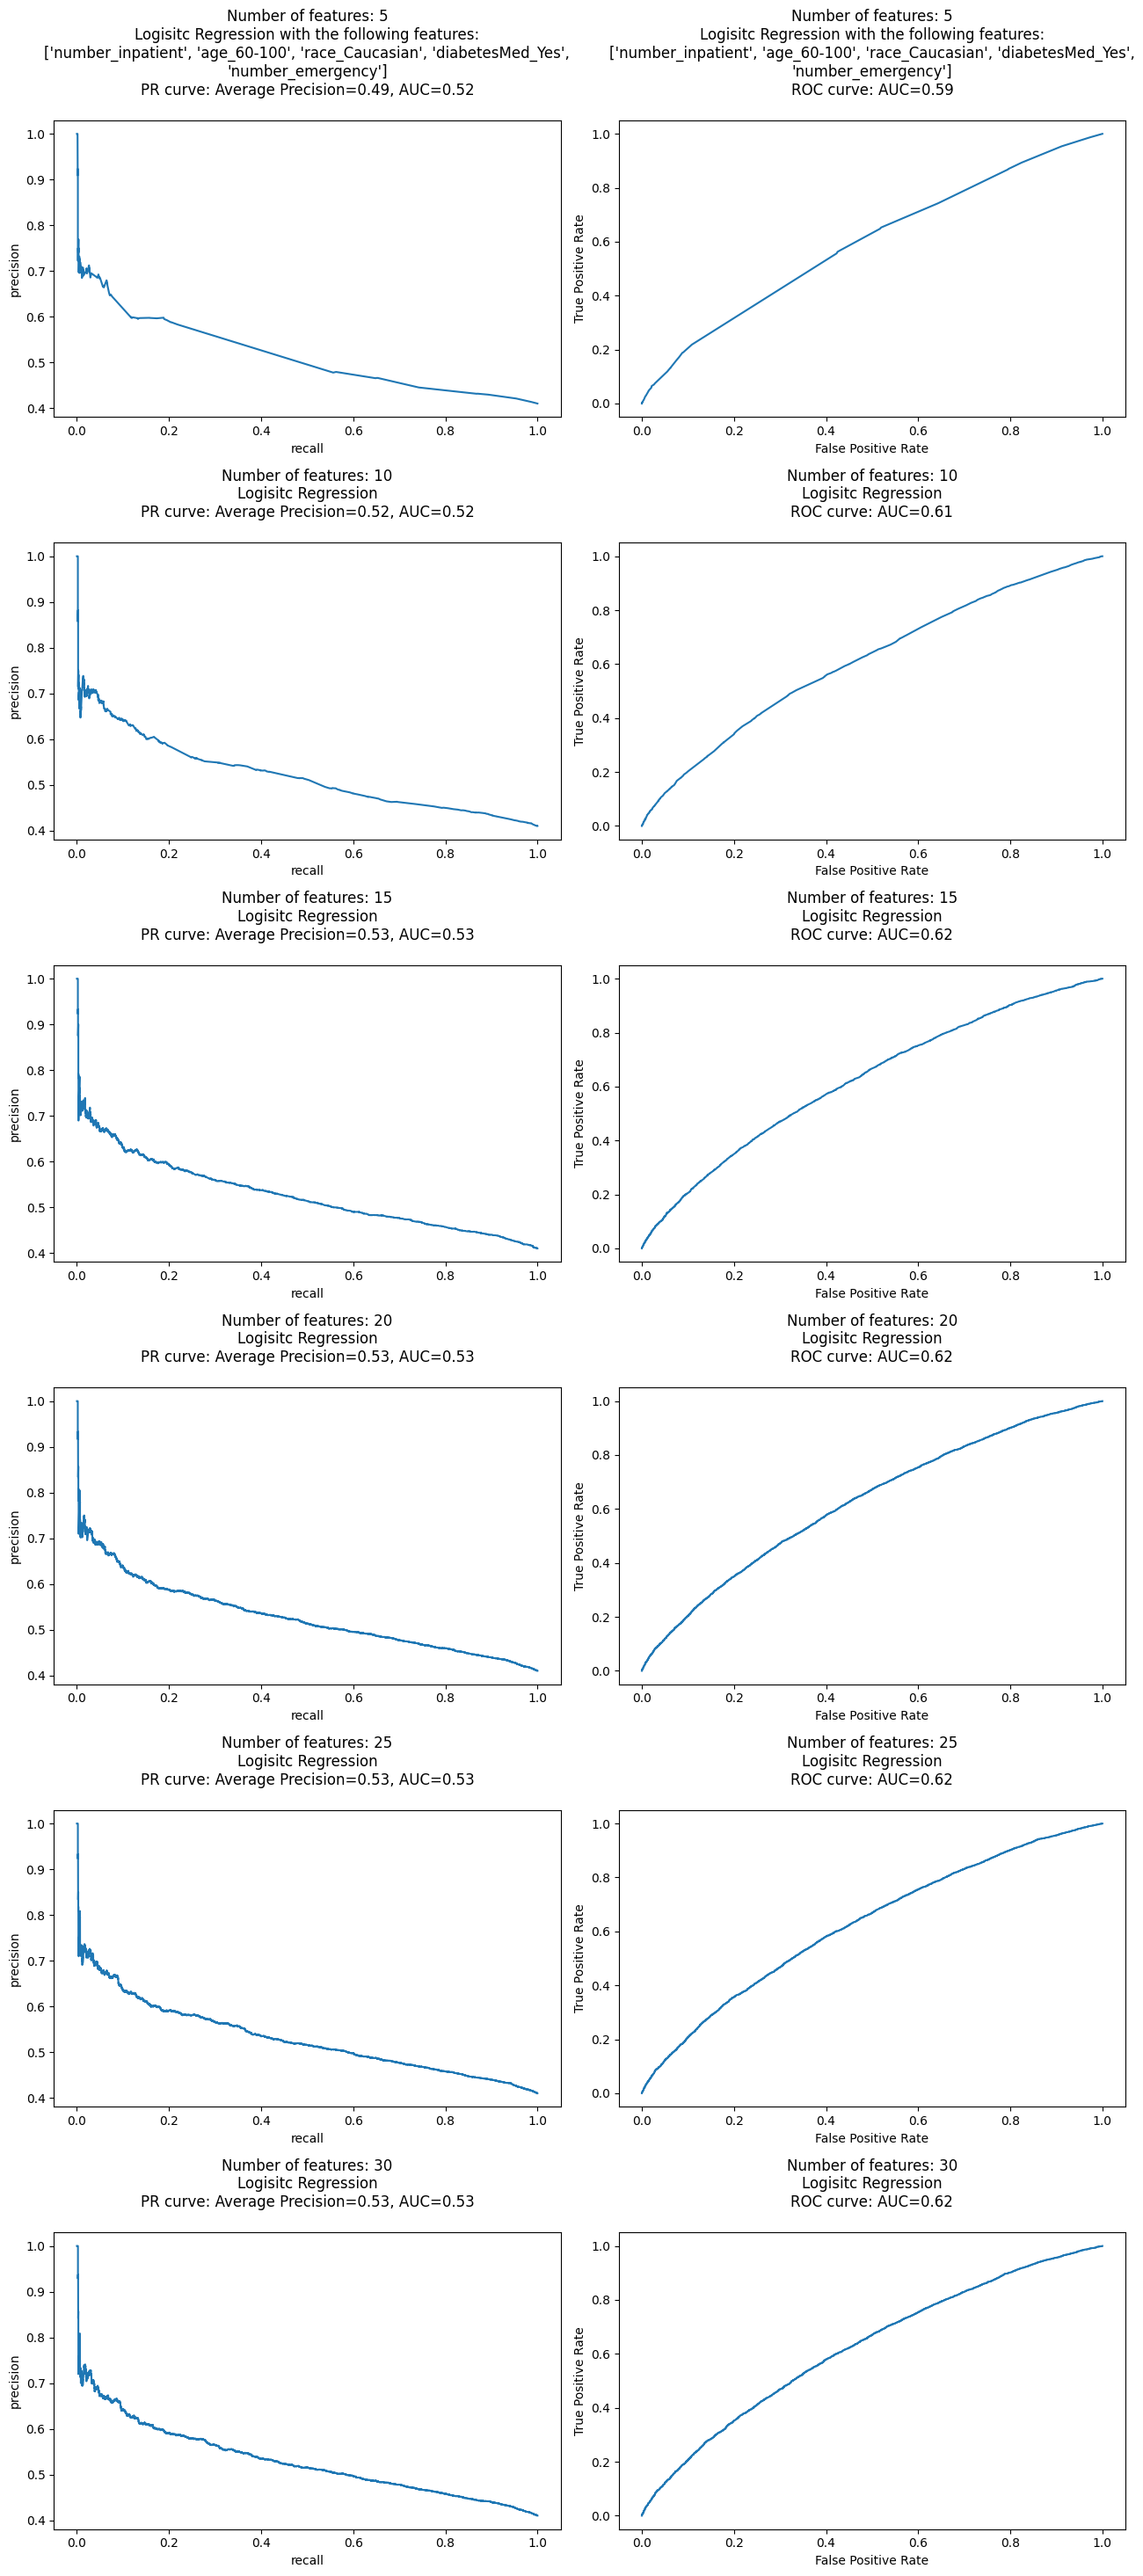

In [ ]:
#@title L1 Logistic regression with top L1 logistic regeression features
set_sizes = [set_size for set_size in range(5,31, 5)]
nrows = len(set_sizes)
fig, axs = plt.subplots(nrows, 2, figsize = (2*6.5, nrows*4.9), layout="tight")
logs = []
for i in range(nrows):
  feature_list = selected_features_l1_reg[0:set_sizes[i]]
  scaler = StandardScaler()
  X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train.loc[:, feature_list]), columns = feature_list)
  X_test_normalized =  pd.DataFrame(scaler.transform(X_test.loc[:, feature_list]), columns = feature_list)
  _, _, log = run_model_and_plot(X_train_normalized, y_train, X_test_normalized, y_test, auc_curves=["pr", "roc"], axs=axs[i], model_parmas={"penalty":"l1", "max_iter": 10000, "random_state": 42, "solver": "saga"} )
  for ax in axs[i]:
    ax.set_title(f'Number of features: {len(feature_list)}\n' + ax.get_title())

## Tree based model

In [ ]:
#@title Trees useful functions
from sklearn.model_selection import cross_validate

def run_random_forest_model(X_train, y_train, X_test, y_test, log, model_parmas={"max_depth":3, "random_state": 42}):
  col_names = list(X_train.columns)
  jumps = 4
  col_str = ",\n".join([str(col_names[start:np.min([start+jumps, len(col_names)]):1]).replace("[","").replace("]","") for start in range(0, len(col_names), jumps)])
  model_title = f'Random Forest with the following features:'
  add_to_log(model_title + str(col_names) +'\n', log)
  title = f'{model_title}\n[{col_str}]\n' if len(X_train.columns) < 8 else 'Random Forest\n'
  # Create classifier using Random Forest
  classifier = RandomForestClassifier(**model_parmas)
  classifier, y_score = run_model(classifier, X_train, y_train, X_test, y_test, title)
  add_to_log(f'classifier coefficients: {list(zip(X_train.columns, classifier.feature_importances_.ravel()))}\n', log)
  return classifier, y_score, title

def run_random_forest_model_and_plot(X_train, y_train, X_test, y_test, axs=None, auc_curves=["pr"], model_parmas={"max_depth":3, "random_state": 42}):
  log = []
  classifier, y_score, title = run_random_forest_model(X_train, y_train, X_test, y_test, log, model_parmas=model_parmas)
  if axs is None:
    fig, axs = plt.subplots(1,len(auc_curves), figsize = (len(auc_curves)*6.5, 4.9))
  curve_results = []
  for ax, curve in zip(axs.flatten(), auc_curves):
    X,Y, thresholds, auc = calc_curve(y_test, y_score, curve, title=title, ax=ax)
    add_to_log(f'{curve} thresholds: {thresholds} \n', log)
    curve_results.append([X,Y, thresholds, auc])
  add_to_log('\n', log)
  return classifier, curve_results, log

def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = {'average_precision': 'average_precision', 'pr_auc_score':pr_auc_score, 'accuracy':'accuracy', 'precision':'precision', 'recall':'recall', 'f1': 'f1'}
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)

      return {"Training average_precision scores": results['train_average_precision'],
              "Mean Training average_precision scores": results['train_average_precision'].mean(),
              "Training Precision-Recall AUC scores": results['train_pr_auc_score'],
              "Mean Training Precision-Recall AUC scores": results['train_pr_auc_score'].mean(),
              "Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation average_precision scores": results['test_average_precision'],
              "Mean Validation average_precision scores": results['test_average_precision'].mean(),
              "Validation Precision-Recall AUC scores": results['test_pr_auc_score'],
              "Mean Validation Precision-Recall AUC scores": results['test_pr_auc_score'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

def print_cross_validation(model, model_name, X, y):
  print("model:", model_name)
  pprint.pprint(cross_validation(model, X, y))

### Find the best model using cross-validation and grid search

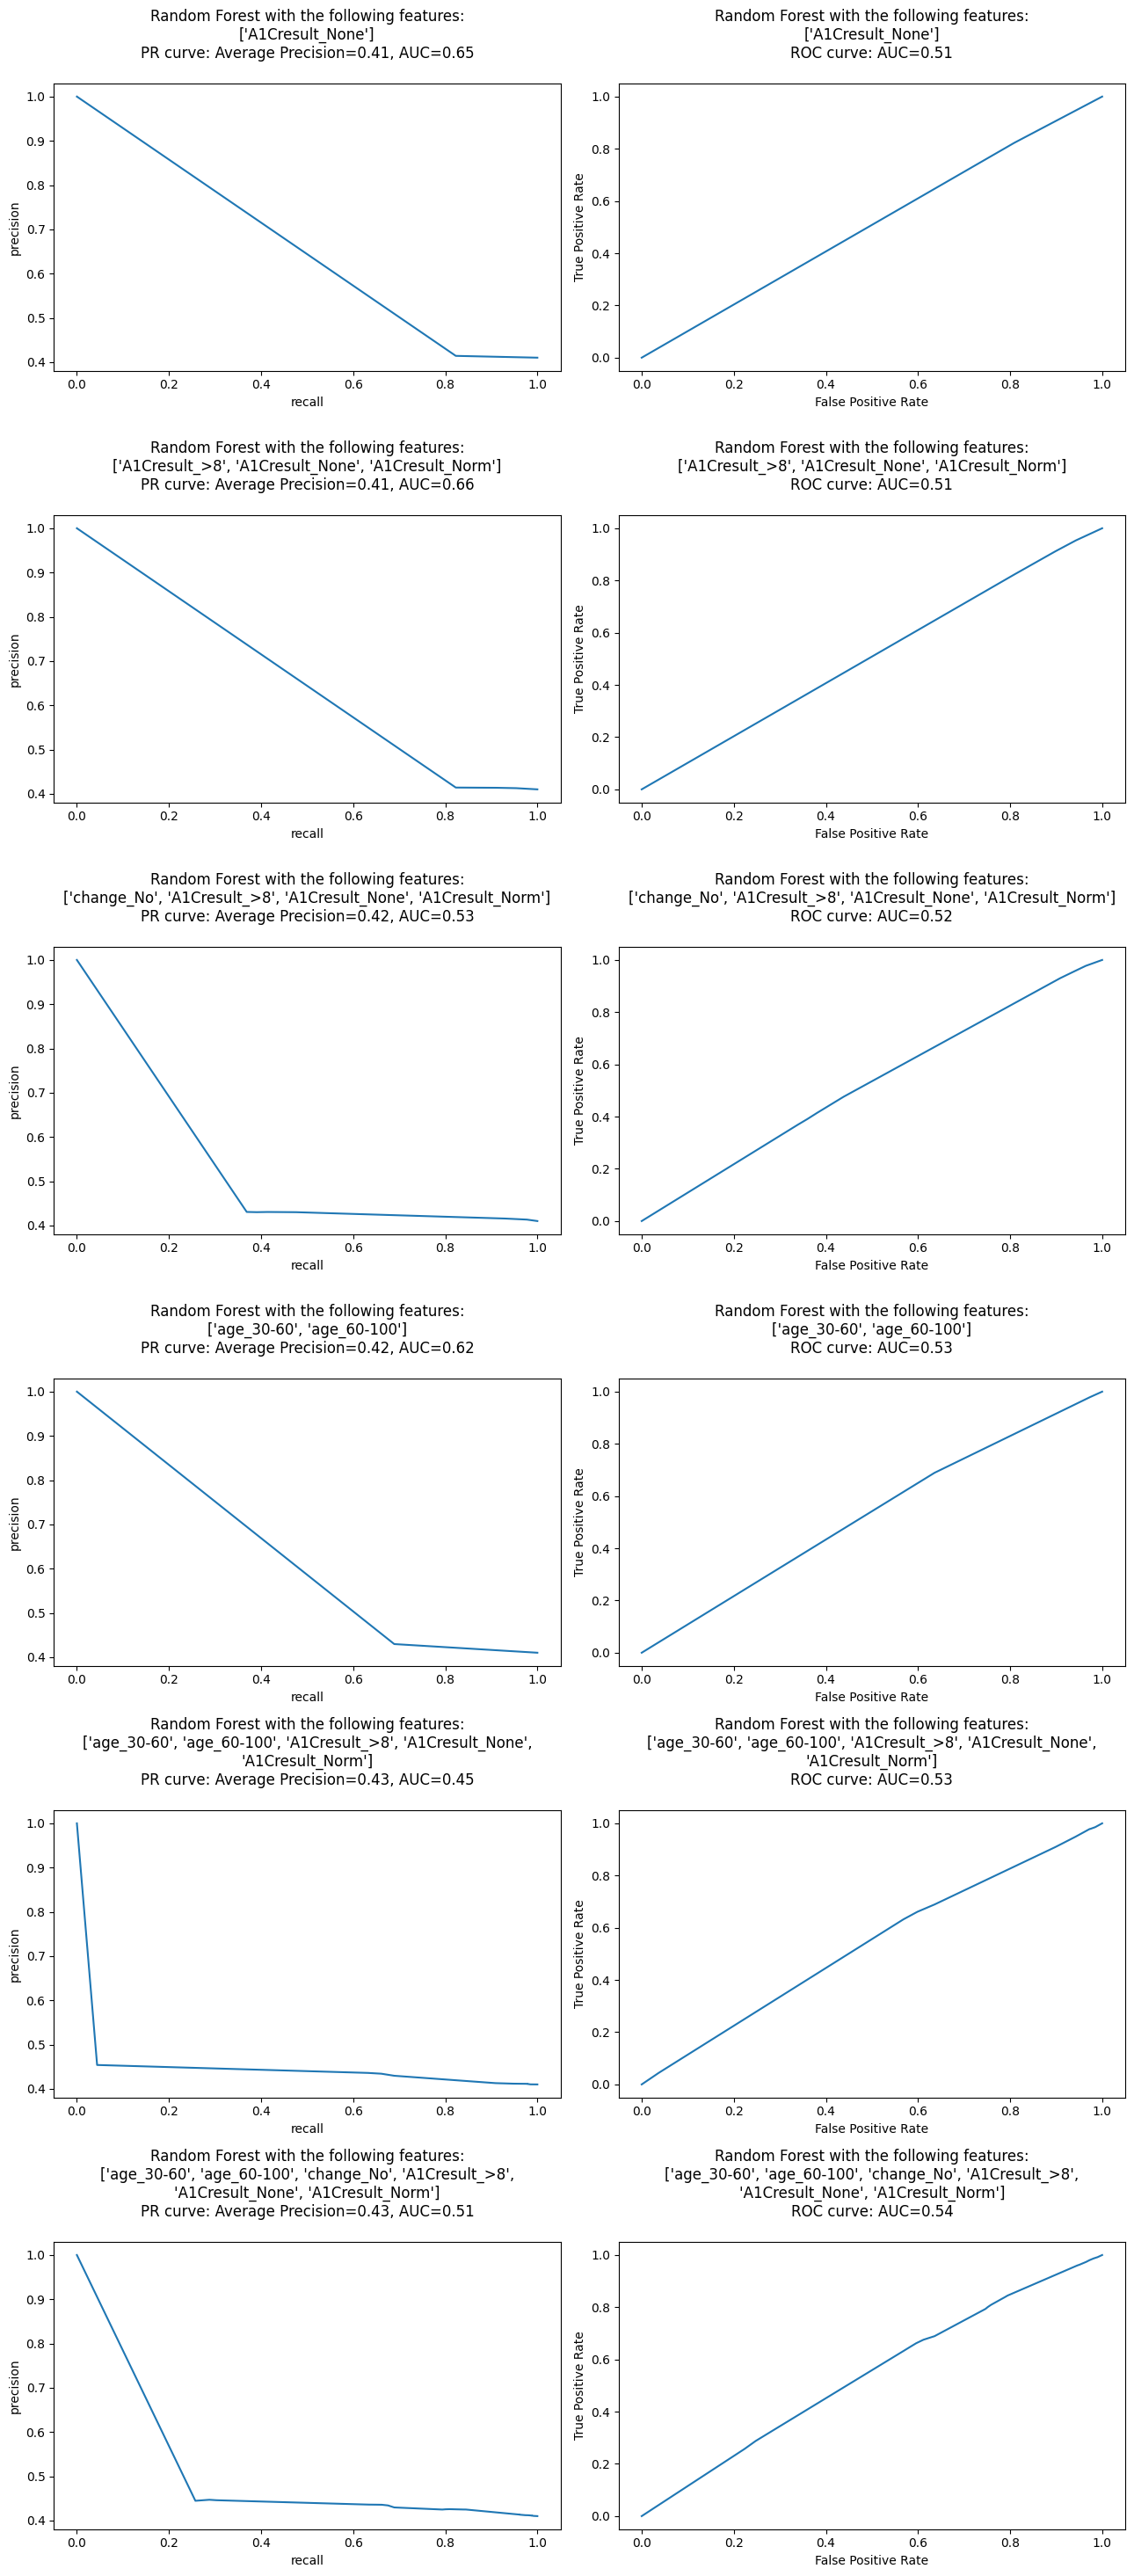

In [ ]:
#@title  Plot PR and ROC curves for basic features as a baseline for trees
from sklearn.ensemble import RandomForestClassifier
import math
features_sets = [['A1Cresult_None'], A1Cresult_cols, change_and_A1Cresult_cols, age_cols, age_cols+A1Cresult_cols, age_cols+change_and_A1Cresult_cols]
nrows = len(features_sets)
fig, axs = plt.subplots(nrows, 2, figsize = (2*6.5, nrows*4.9), layout="tight")
logs = []
for i in range(nrows):
  _, _, log = run_random_forest_model_and_plot(X_train.loc[:, features_sets[i]], y_train, X_test.loc[:, features_sets[i]], y_test, axs=axs[i, :], auc_curves=["pr", "roc"], model_parmas={"max_depth":3, "random_state": 42})
  logs.extend(log)

**Summary:** Logistic regression perfomrs better than Random Forest on basic feature sets

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
models = [(RandomForestClassifier(), {'min_samples_split': [2, 5, 10], 'max_depth': [None] + [i for i in range(3,16, 2)], 'random_state': [42]}, "RandomForest"),
          (GradientBoostingClassifier(), {'min_samples_split': [2, 5, 10], 'max_depth': [None] + [i for i in range(3,16, 2)] , 'random_state': [42]}, "XGBoost")
          ]
top_estimators = []
for model in models:
  clf = GridSearchCV(model[0], param_grid = model[1], scoring='average_precision')
  clf.fit(processed_data.loc[:, X_train.columns], y)
  top_estimators += clf.best_estimator_
  print_cross_validation(clf.best_estimator_, "_".join([model[2], str(clf.best_params_)]) ,processed_data, y)

model: RandomForest_{'max_depth': 13, 'min_samples_split': 10, 'random_state': 42}
{'Mean Training Accuracy': 68.37315922800428,
 'Mean Training F1 Score': 0.43951970329628287,
 'Mean Training Precision': 0.7898404791524929,
 'Mean Training Precision-Recall AUC scores': 0.6988662748900787,
 'Mean Training Recall': 0.3045019872370518,
 'Mean Training average_precision scores': 0.6988751126431524,
 'Mean Validation Accuracy': 62.0210829905513,
 'Mean Validation F1 Score': 0.33782837060027504,
 'Mean Validation Precision': 0.6022833741084426,
 'Mean Validation Precision-Recall AUC scores': 0.5354430265971875,
 'Mean Validation Recall': 0.24818582515245824,
 'Mean Validation average_precision scores': 0.5355656738939831,
 'Training Accuracy scores': array([0.68403659, 0.68623388, 0.68375076, 0.68348845, 0.68114829]),
 'Training F1 scores': array([0.44329735, 0.44638467, 0.4400797 , 0.43727371, 0.43056309]),
 'Training Precision scores': array([0.78488631, 0.79321161, 0.78895441, 0.79244849

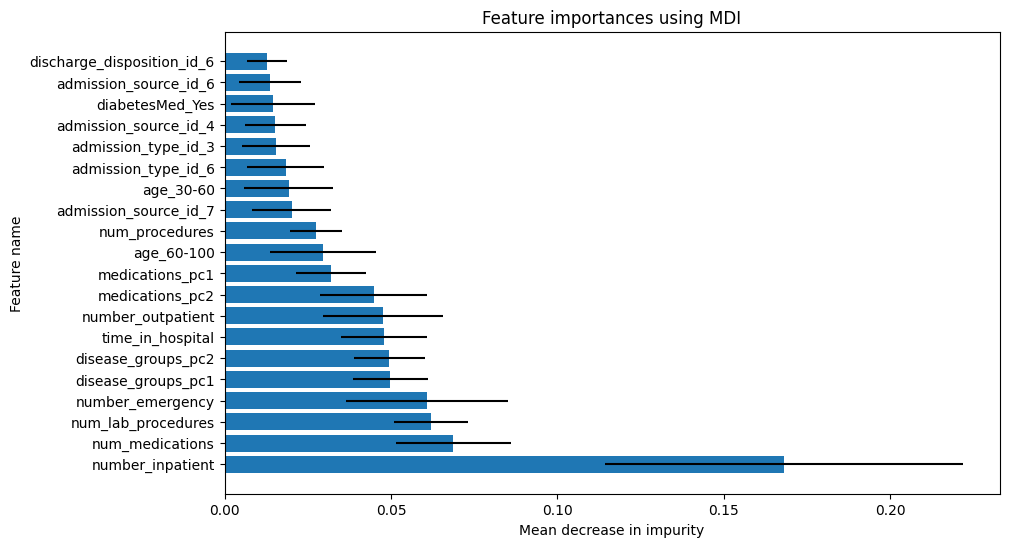

In [ ]:
# Feature importance with random forest
from sklearn.ensemble import RandomForestClassifier
# Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.
forest = RandomForestClassifier(max_depth= 11, min_samples_split= 10, random_state= 42) # parameters were fine tuned after cross validatinig
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
selected_features_mdi = plot_and_select_features(X_train.columns, importances, xerr=std, top_features=20, title="Feature importances using MDI", xlabel="Mean decrease in impurity")

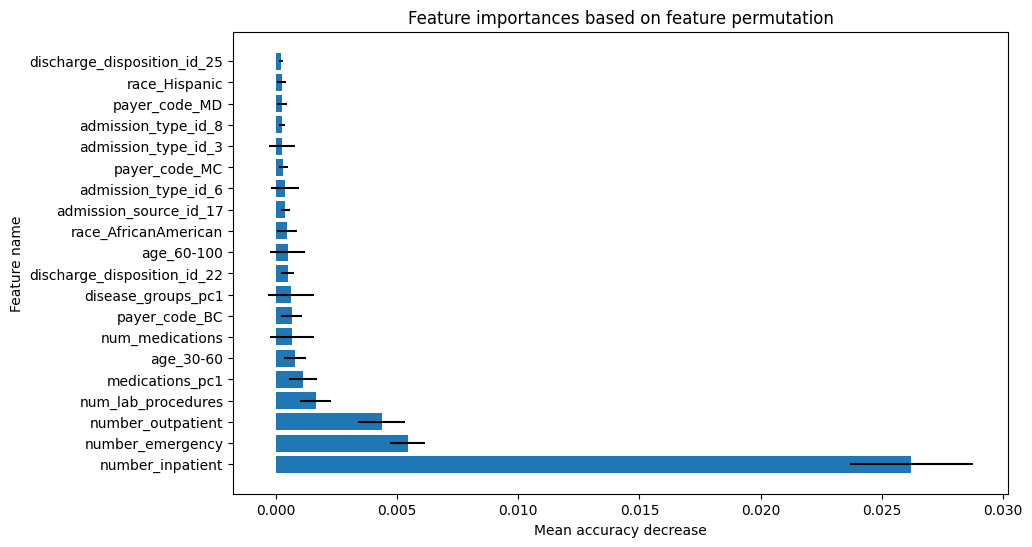

In [ ]:
# Feature importance based on feature permutation
from sklearn.inspection import permutation_importance
result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42)

selected_features_permutation = plot_and_select_features(X_train.columns, result.importances_mean, xerr=result.importances_std, top_features=20, title="Feature importances based on feature permutation", xlabel="Mean accuracy decrease")

## Cluster using UMAP

In [ ]:
# ! pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=6c398f2f862911bfb68a080a9223fb9512496d49f3f92558f491115458d16160
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=f7b64b9ac54dda0948640be29c037cd4d0580da84e746cf5c07f3b49b832c7ee
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
# import umap

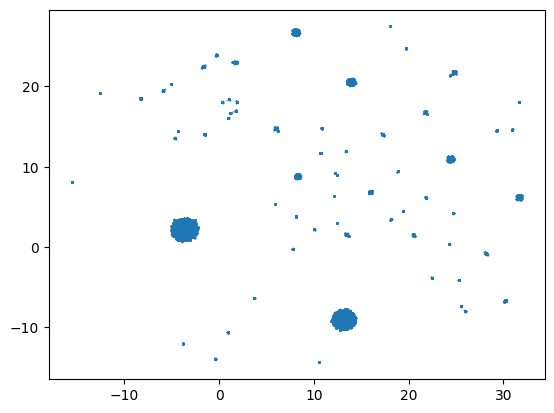

In [ ]:
# clusterable_embedding = umap.UMAP(n_neighbors=30,
#                                   min_dist=0.0,
#                                   n_components=2,
#                                   random_state=42,
#                                   ).fit_transform(data[medications].apply(lambda x: x.map(trans_med)))
# plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1)

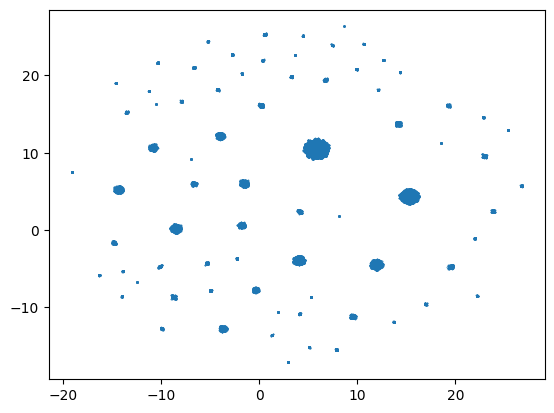

In [ ]:
# standard_embedding = umap.UMAP(random_state=42).fit_transform(one_hot_encoded_data[disease_groups.keys()])
# plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1)

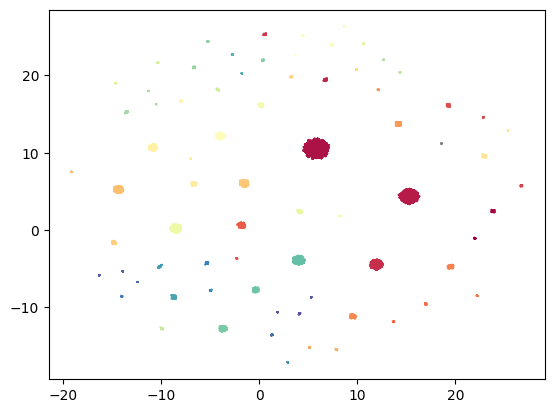

In [ ]:
# clustered = (labels >= 0)
# plt.scatter(standard_embedding[~clustered, 0],
#             standard_embedding[~clustered, 1],
#             color=(0.5, 0.5, 0.5),
#             s=0.1,
#             alpha=0.5)
# plt.scatter(standard_embedding[clustered, 0],
#             standard_embedding[clustered, 1],
#             c=labels[clustered],
#             s=0.1,
#             cmap='Spectral');